Home Credit provides loans to unbanked customers. They want to identify who will be able to repay and who wont

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
# Metrics for model selection
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, cross_val_score, train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, precision_recall_curve, precision_score, \
recall_score, confusion_matrix

# Importing Models -- LightBoost, Logistic, Randomforest
import lightgbm as lgb
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.preprocessing import LabelEncoder

from sklearn.preprocessing import Imputer # For Missing Value Imputation
#from fancyimpute import KNN # For using KNN Imputation -- Note might have to download fancyimute package


In [6]:
app_train = pd.read_csv('application_train.csv')

In [7]:
app_test = pd.read_csv('application_test.csv')

In [8]:
app_train.shape

(307511, 122)

In [9]:
app_train.columns.values

array(['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER',
       'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN',
       'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE',
       'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE',
       'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE',
       'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE',
       'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'OCCUPATION_TYPE',
       'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT',
       'REGION_RATING_CLIENT_W_CITY', 'WEEKDAY_APPR_PROCESS_START',
       'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION',
       'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION',
       'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY',
       'LIVE_CITY_NOT_WORK_CITY', 'ORGANIZATION_TYPE', 'EXT_SOURCE_1',
       'EXT_SOURCE_2', 'EXT_SOURCE_3',

In [12]:
app_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
missing_values = (app_train.isna().sum()*100/len(app_train)).sort_values(ascending = False)
pd.DataFrame(missing_values,columns=['missing_values_percent'])[:20]

,missing_values_percent
COMMONAREA_MEDI,69.872297
COMMONAREA_AVG,69.872297
COMMONAREA_MODE,69.872297
NONLIVINGAPARTMENTS_MODE,69.432963
NONLIVINGAPARTMENTS_MEDI,69.432963
NONLIVINGAPARTMENTS_AVG,69.432963
FONDKAPREMONT_MODE,68.386172
LIVINGAPARTMENTS_MEDI,68.354953
LIVINGAPARTMENTS_MODE,68.354953
LIVINGAPARTMENTS_AVG,68.354953


We will either impute missing values, or drop these columns or use techniques like LightBoost/XG Boost whihc automatically take care of missing values! 

### EDA

1. Distribution of target column

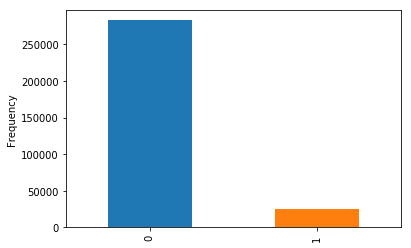

In [14]:
app_train['TARGET'].astype(int).plot.hist()
app_train['TARGET'].value_counts().plot(kind = 'bar')

Clearly imbalaced class problem! Far more loas repaid on time than the ones not paid on time! 

In [15]:
# Column types
app_train.dtypes.value_counts()

float64    65
int64      41
object     16
dtype: int64

Handling categorical variables

Label Encoding - But can introduce unnecessary ordering, which is not needed

One Hot Encoding - It's a safe and good option, but it can explode our feature space. So, maybe OHE could be followed by PCA (or other dimensionality reduction methods) to reduce the dimension space and identify the most important variables 

So we will use Label Encoding for variables with 2 categoris and OHE (pd.get_dummies) for caegorical variables with more than 2 unique categories.

In [16]:
#Auto encodes any dataframe column of type category or object.
def dummyEncode(df):
        columnsToEncode = list(df.select_dtypes(include=['category','object']))
        le = LabelEncoder()
        for feature in columnsToEncode:
            if df[feature].nunique() <= 2:
                try:
                    df[feature] = le.fit_transform(df[feature])
                except:
                    print('Error encoding '+feature)
        return df
    
app_train = dummyEncode(app_train)


Error encoding EMERGENCYSTATE_MODE


**OHE for the remainig columns**

In [17]:
app_train = pd.get_dummies(app_train)

**Repeat the above process for test data**

In [18]:
app_test = dummyEncode(app_test)
app_test = pd.get_dummies(app_test)

Error encoding EMERGENCYSTATE_MODE


In [19]:
print ('Training data shape',app_train.shape)
print ('Test data shape',app_test.shape)

Training data shape (307511, 243)
Test data shape (48744, 238)


OHE created extra columns in train data, while less in test data because some categories not present in test data

In [20]:
train_labels = app_train['TARGET']

# Align the training and testing data, keep only columns present in both dataframes
app_train, app_test = app_train.align(app_test, join = 'inner', axis = 1)

# This will also remove the target variable. We want that variable

app_train['TARGET'] =  train_labels


In [21]:
print ('Training data shape',app_train.shape)
print ('Test data shape',app_test.shape)

Training data shape (307511, 238)
Test data shape (48744, 237)


Now the featues in train and test data are similar! 

**Let's look out for anomalies in the data** - Note this section is optional - do only if time permits

In [22]:
(app_train['DAYS_BIRTH'] / -365).describe()

count    307511.000000
mean         43.936973
std          11.956133
min          20.517808
25%          34.008219
50%          43.150685
75%          53.923288
max          69.120548
Name: DAYS_BIRTH, dtype: float64

The age looks reasonable

In [23]:
(app_train['DAYS_EMPLOYED']/365).describe()

count    307511.000000
mean        174.835742
std         387.056895
min         -49.073973
25%          -7.561644
50%          -3.323288
75%          -0.791781
max        1000.665753
Name: DAYS_EMPLOYED, dtype: float64

The days employed seems to be weird! 1000 years! Min is negative. The mean is also too high (possibly due to outlier?) 

Text(0.5,1,'Days Employed Histogram')

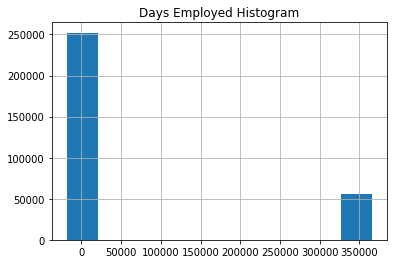

In [24]:
app_train['DAYS_EMPLOYED'].hist()
plt.title('Days Employed Histogram')

In [25]:
app_train['DAYS_EMPLOYED'].max()

365243

Once we have handeled this data - Let's see the correlated variables with our target variable

In [26]:
correlations = app_train.corr()['TARGET'].sort_values(ascending = False)

In [27]:
print('Most positive correlations\n',correlations.head(10))
print ('ost negative correlations\n',correlations.tail(10))

Most positive correlations
 TARGET                                               1.000000
DAYS_BIRTH                                           0.078239
REGION_RATING_CLIENT_W_CITY                          0.060893
REGION_RATING_CLIENT                                 0.058899
NAME_INCOME_TYPE_Working                             0.057481
DAYS_LAST_PHONE_CHANGE                               0.055218
DAYS_ID_PUBLISH                                      0.051457
REG_CITY_NOT_WORK_CITY                               0.050994
NAME_EDUCATION_TYPE_Secondary / secondary special    0.049824
FLAG_EMP_PHONE                                       0.045982
Name: TARGET, dtype: float64
ost negative correlations
 FLOORSMAX_MODE                         -0.043226
FLOORSMAX_MEDI                         -0.043768
FLOORSMAX_AVG                          -0.044003
DAYS_EMPLOYED                          -0.044932
ORGANIZATION_TYPE_XNA                  -0.045987
NAME_INCOME_TYPE_Pensioner             -0.046209
NA

Clearly looking at the top correlations, we find that age (days_birth) has most positive correlation, EXT_SOURCE_1/2/3 have the most negative correlations. 

We will take a look at these variables

Text(0,0.5,'Frequency')

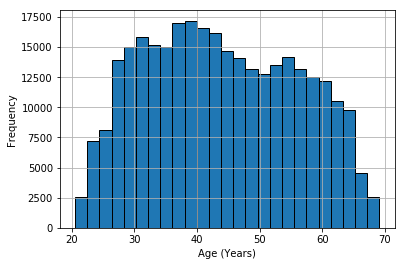

In [28]:
(app_train['DAYS_BIRTH']/-365).hist(bins=25,edgecolor = 'k') # Edgecolor helps to distinguish histograms

plt.xlabel('Age (Years)')
plt.ylabel('Frequency')


Impact of age (days_birth) on Target

**Continuous vs categorical data -> Either a distribution or boxplot**

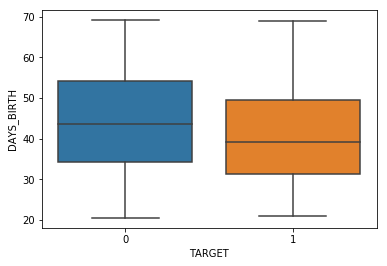

In [29]:
sns.boxplot(x = app_train.TARGET, y = app_train.DAYS_BIRTH/-365 )

As we can see form the above graph, younger people are more likely to default

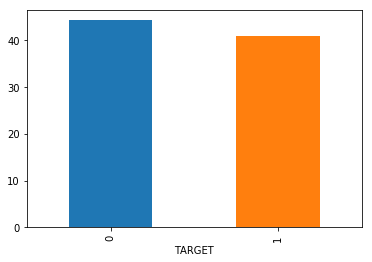

In [30]:
(app_train.groupby('TARGET')['DAYS_BIRTH'].mean()/-365).plot(kind = 'bar')

For the above we can also make a distribution plot! Using seaborn)

C:\Users\bandi\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0,0.5,'Density')

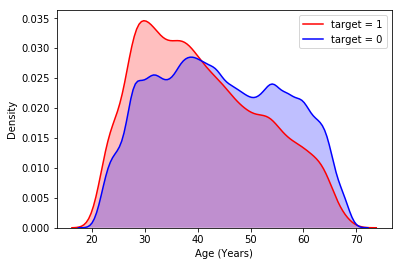

In [31]:
sns.kdeplot(app_train.DAYS_BIRTH[app_train['TARGET']==1]/-365, color = 'Red', shade = True, label = 'target = 1')
sns.kdeplot(app_train.DAYS_BIRTH[app_train['TARGET']==0]/-365, color = 'Blue', shade = True, label = 'target = 0')

plt.xlabel('Age (Years)')
plt.ylabel('Density')            

C:\Users\bandi\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:448: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
C:\Users\bandi\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:448: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
C:\Users\bandi\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0,0.5,'Density')

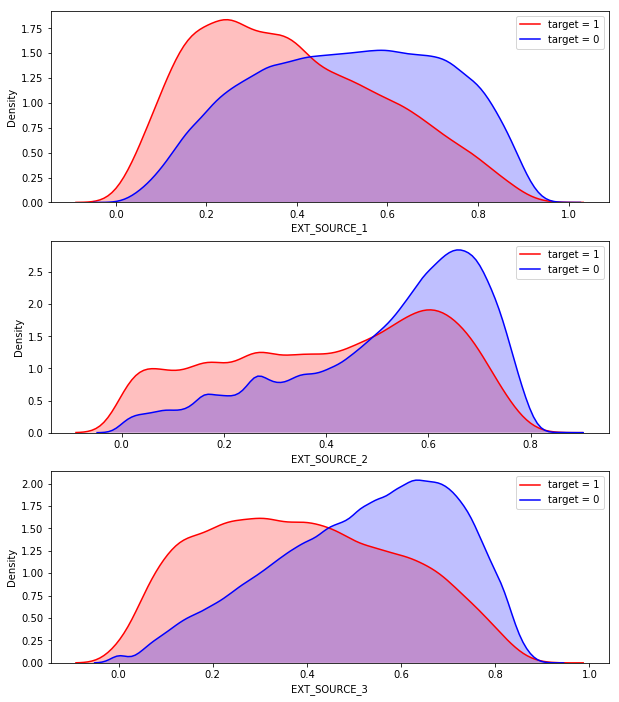

In [32]:
f, (ax1,ax2,ax3) = plt.subplots(nrows = 3, ncols = 1, figsize = (10,12))

sns.kdeplot(app_train.EXT_SOURCE_1[app_train['TARGET']==1], color = 'Red', shade = True, label = 'target = 1',ax = ax1)
sns.kdeplot(app_train.EXT_SOURCE_1[app_train['TARGET']==0], color = 'Blue', shade = True, label = 'target = 0',ax=ax1)
ax1.set_xlabel('EXT_SOURCE_1')
ax1.set_ylabel('Density')

sns.kdeplot(app_train.EXT_SOURCE_2[app_train['TARGET']==1], color = 'Red', shade = True, label = 'target = 1',ax = ax2)
sns.kdeplot(app_train.EXT_SOURCE_2[app_train['TARGET']==0], color = 'Blue', shade = True, label = 'target = 0', ax=ax2)
ax2.set_xlabel('EXT_SOURCE_2')
ax2.set_ylabel('Density')

sns.kdeplot(app_train.EXT_SOURCE_3[app_train['TARGET']==1], color = 'Red', shade = True, label = 'target = 1',ax = ax3)
sns.kdeplot(app_train.EXT_SOURCE_3[app_train['TARGET']==0], color = 'Blue', shade = True, label = 'target = 0', ax=ax3)
ax3.set_xlabel('EXT_SOURCE_3')
ax3.set_ylabel('Density')       

EXT_SOURCE 3 has a larger difference between targets. It could be an imporant variable - Write some hypothesis around it.

**Categorical Feature vs Target Variable** 

In [33]:
app_train['NAME_FAMILY_STATUS_Single / not married'].value_counts()

0    262067
1     45444
Name: NAME_FAMILY_STATUS_Single / not married, dtype: int64

In [34]:
family_status_target =  app_train.groupby(['NAME_FAMILY_STATUS_Single / not married','TARGET']).size().unstack()

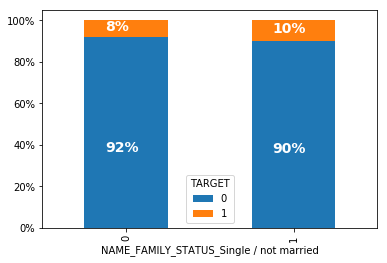

In [35]:
ax = (family_status_target.T*100/family_status_target.T.sum()).T.plot(kind = 'bar', stacked = True)
ax.yaxis.set_major_formatter(mtick.PercentFormatter())

# Code to add the data labels on the stacked bar chart
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.annotate('{:.0f}%'.format(height), (p.get_x()+.25*width, p.get_y()+.4*height),
                color = 'white',
               weight = 'bold',size =14)

**Handling Missing Values**

1. Case Deletion

    a. Complete case deletion - Remove all instances with missing values
    
    b. Pair deletion
    
    c. We can also create a column with missing values! df[‘New’]=np.nan
    

2. Imputation

    a. Statistical methods (Mean, Median, Mode, Linear Regression). Linear regression imputation reduces variablility and over-estimates model fit
    
    b. ML based methods (KNN)
    
    
Note - df.dropna() removes the entire row if there is one NA in it. df.dropna(how = 'all') removes the row only if NA in all the columsn.


**a. Statistical Imputation Using sklearn.processing import Imputer**

In [36]:
# Making a separate dataframe
poly_features = app_train[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH', 'TARGET']]
poly_features_test = app_test[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]

In [37]:
# Linear Interpolation - Useful for timeseries data, but not otherwise
#poly_features['EXT_SOURCE_1'].interpolate(method='linear', inplace=True, limit_direction="both")

In [38]:
from sklearn.preprocessing import Imputer # Another imputation package is fancyimpute
# Impute with median values
imputer = Imputer(strategy = 'median') # Other strategy are 'mean', 'most_frequent'. axis = 0 means rows
poly_target = poly_features['TARGET']

poly_features = poly_features.drop(columns = ['TARGET'])

C:\Users\bandi\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [39]:
# Need to impute missing values
poly_features = imputer.fit_transform(poly_features) #fit_transform automatically fits and transforms the data
poly_features_test = imputer.transform(poly_features_test) # just transform on test data

**b. KNN Imputation**

1. Based on the KNN algorithm. Values obtained using similarity based methods that rely on distance metrics such as Euclidian distance, Jacard similarity, cosine similarity

2. They can be used for both discrete and continuous variables

The biggest disadvantage when analyzing large data sets is that it searches for similar instances through the entire data set.
So makes the process very slow. further the accuracy is ery in case of multiple variables.

fancyimpute.kNN(k=x).complete(data matrix) is used for KNN imputation

**In R - this is how it works - **

library(DMwR)

knnOutput <- knnImputation(mydata)

In [1]:
# #from fancyimpute import KNN

# ! pip install fancyimpute

  Using cached https://files.pythonhosted.org/packages/37/c2/b42ea6172165163bb5373e761fee18f1e7d3c37834679c6a4afdaae1d401/cvxpy-1.0.19.tar.gz
  Using cached https://files.pythonhosted.org/packages/b3/fd/6e01c4f4a69fcc6c3db130ba55572089e78e77ea8c0921a679f9da1ec04c/scs-2.0.2.tar.gz
    Complete output from command python setup.py egg_info:
    Traceback (most recent call last):
      File "<string>", line 1, in <module>
      File "C:\Users\bandi\AppData\Local\Temp\pip-install-nztl20jp\scs\setup.py", line 237, in <module>
        run_install()
      File "C:\Users\bandi\AppData\Local\Temp\pip-install-nztl20jp\scs\setup.py", line 54, in run_install
        blas_info = get_info('blas_opt')
      File "c:\users\bandi\anaconda3\lib\site-packages\numpy\distutils\system_info.py", line 445, in get_info
        return cl().get_info(notfound_action)
      File "c:\users\bandi\anaconda3\lib\site-packages\numpy\distutils\system_info.py", line 638, in get_info
        self.calc_info()
      File "c:

Command "python setup.py egg_info" failed with error code 1 in C:\Users\bandi\AppData\Local\Temp\pip-install-nztl20jp\scs\


**Feature Engineering (Optional)**

One simple method is polynomial features - We will do so below and also conduct imputation

In [43]:
from sklearn.preprocessing import PolynomialFeatures                                  
# Create the polynomial object with specified degree
poly_transformer = PolynomialFeatures(degree = 3)

#Train 
poly_transformer.fit(poly_features)

#Transform
poly_features = poly_transformer.transform(poly_features)
poly_features_test = poly_transformer.transform(poly_features_test)

poly_features.shape

(307511, 35)

In [46]:
poly_transformer.get_feature_names(input_features = ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH'])

['1',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'DAYS_BIRTH',
 'EXT_SOURCE_1^2',
 'EXT_SOURCE_1 EXT_SOURCE_2',
 'EXT_SOURCE_1 EXT_SOURCE_3',
 'EXT_SOURCE_1 DAYS_BIRTH',
 'EXT_SOURCE_2^2',
 'EXT_SOURCE_2 EXT_SOURCE_3',
 'EXT_SOURCE_2 DAYS_BIRTH',
 'EXT_SOURCE_3^2',
 'EXT_SOURCE_3 DAYS_BIRTH',
 'DAYS_BIRTH^2',
 'EXT_SOURCE_1^3',
 'EXT_SOURCE_1^2 EXT_SOURCE_2',
 'EXT_SOURCE_1^2 EXT_SOURCE_3',
 'EXT_SOURCE_1^2 DAYS_BIRTH',
 'EXT_SOURCE_1 EXT_SOURCE_2^2',
 'EXT_SOURCE_1 EXT_SOURCE_2 EXT_SOURCE_3',
 'EXT_SOURCE_1 EXT_SOURCE_2 DAYS_BIRTH',
 'EXT_SOURCE_1 EXT_SOURCE_3^2',
 'EXT_SOURCE_1 EXT_SOURCE_3 DAYS_BIRTH',
 'EXT_SOURCE_1 DAYS_BIRTH^2',
 'EXT_SOURCE_2^3',
 'EXT_SOURCE_2^2 EXT_SOURCE_3',
 'EXT_SOURCE_2^2 DAYS_BIRTH',
 'EXT_SOURCE_2 EXT_SOURCE_3^2',
 'EXT_SOURCE_2 EXT_SOURCE_3 DAYS_BIRTH',
 'EXT_SOURCE_2 DAYS_BIRTH^2',
 'EXT_SOURCE_3^3',
 'EXT_SOURCE_3^2 DAYS_BIRTH',
 'EXT_SOURCE_3 DAYS_BIRTH^2',
 'DAYS_BIRTH^3']

In [48]:
poly_features = pd.DataFrame(poly_features,columns = poly_transformer.get_feature_names\
                             (input_features = ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']))

In [49]:
#Add taret 
poly_features['TARGET'] = poly_target
poly_features.corr()['TARGET'].sort_values()

EXT_SOURCE_2 EXT_SOURCE_3                -0.193939
EXT_SOURCE_1 EXT_SOURCE_2 EXT_SOURCE_3   -0.189605
EXT_SOURCE_2^2 EXT_SOURCE_3              -0.176428
EXT_SOURCE_2 EXT_SOURCE_3^2              -0.172282
EXT_SOURCE_1 EXT_SOURCE_2                -0.166625
EXT_SOURCE_1 EXT_SOURCE_3                -0.164065
EXT_SOURCE_2                             -0.160295
EXT_SOURCE_1 EXT_SOURCE_2^2              -0.156867
EXT_SOURCE_3                             -0.155892
EXT_SOURCE_1 EXT_SOURCE_3^2              -0.150822
EXT_SOURCE_2^2                           -0.149512
EXT_SOURCE_3^2                           -0.141662
EXT_SOURCE_2^3                           -0.140243
EXT_SOURCE_1^2 EXT_SOURCE_2              -0.140185
EXT_SOURCE_1^2 EXT_SOURCE_3              -0.138846
EXT_SOURCE_2 DAYS_BIRTH^2                -0.132839
EXT_SOURCE_3^3                           -0.128213
EXT_SOURCE_3 DAYS_BIRTH^2                -0.126950
EXT_SOURCE_1                             -0.098887
EXT_SOURCE_1 DAYS_BIRTH^2      

Interestingly several ne variables have a high correlation. In our ML model we can try with and without these.

In [ ]:
poly_features_test = pd.DataFrame(poly_features_test,columns = poly_transformer.get_feature_names\
                             (input_features = ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']))

**Scaling the data**

In [42]:
# Scaling all the variables to a range of 0 to 1
from sklearn.preprocessing import MinMaxScaler
features = X.columns.values
scaler = MinMaxScaler(feature_range = (0,1))
scaler.fit(X)
X = pd.DataFrame(scaler.transform(X))
X.columns = features

(307511, 4)

### Predictive Models

In [ ]:
from sklearn.linear_model import LogisticRegression

# Make the model with the specified regularization parameter
log_reg = LogisticRegression(C = 0.0001)

# Train on the training data
log_reg.fit(train, train_labels)

**Accuracy**